<a href="https://colab.research.google.com/github/Dau2004/Child-Malnutrition-Classification/blob/main/Summative_Assignment_Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malnutrition Classification Project
# Optimizing Models for Child Malnutrition Detection

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load dataset
df = pd.read_csv('/content/malnutrition_data (1).csv')

# Display dataset info
print("Dataset Info:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

Dataset Info:
Shape: (5000, 6)

First 5 rows:


,age_months,weight_kg,height_cm,muac_cm,bmi,nutrition_status
0,12.345052,3.000000,54.134002,13.160919,10.0,normal
1,30.807200,5.459076,76.199180,13.944380,10.0,normal
2,15.723226,3.000000,60.280820,13.243565,10.0,normal
3,57.796256,10.103074,104.990471,14.105683,10.0,normal
4,40.321320,7.110583,85.277902,14.641630,10.0,normal


In [4]:
# Class distribution
print("\nClass Distribution:")
print(df['nutrition_status'].value_counts())


Class Distribution:
nutrition_status
normal      3550
moderate    1100
severe       350
Name: count, dtype: int64


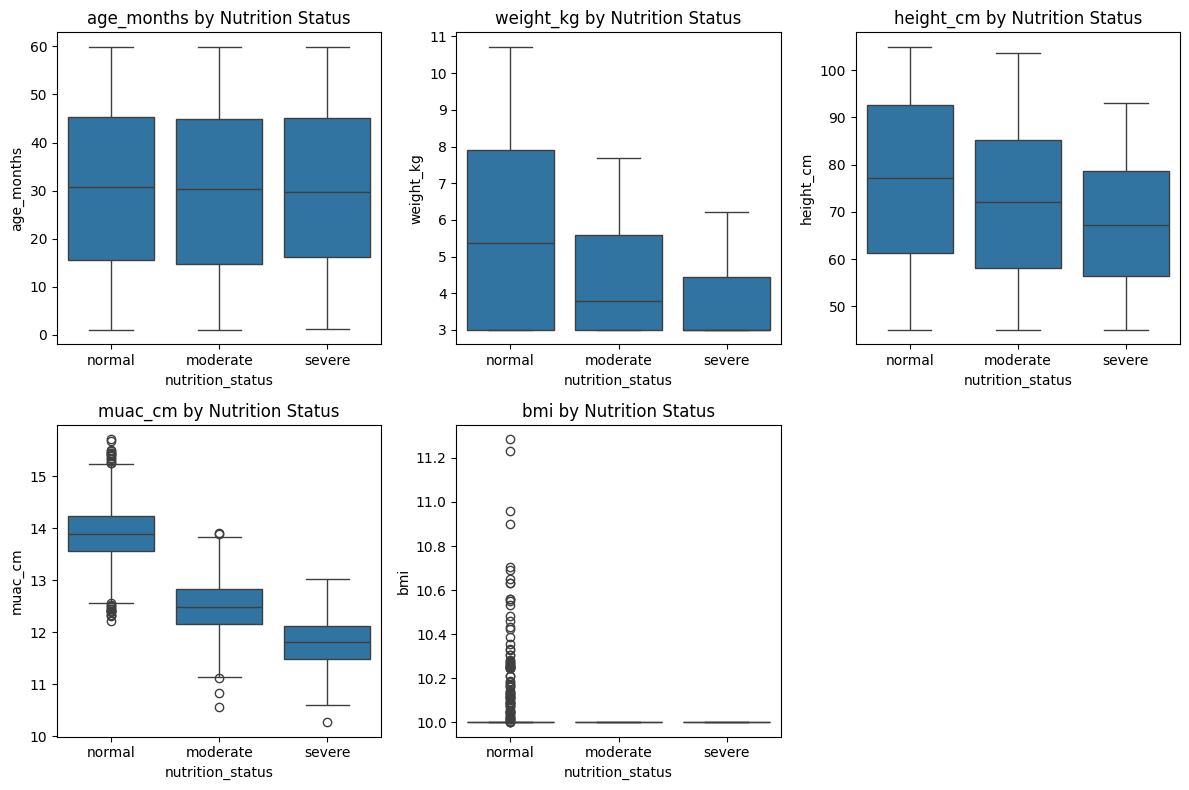

In [5]:
# Visualize feature distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='nutrition_status', y=col, data=df)
    plt.title(f'{col} by Nutrition Status')
plt.tight_layout()
plt.show()

# Preprocessing

In [6]:
# Preprocessing
def preprocess_data(df):
    """Preprocess malnutrition dataset"""
    # Encode target variable
    le = LabelEncoder()
    df['nutrition_status'] = le.fit_transform(df['nutrition_status'])

    # Separate features and target
    X = df.drop('nutrition_status', axis=1)
    y = df['nutrition_status']

    # Split data (70% train, 15% validation, 15% test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Save scaler for later use
    joblib.dump(scaler, 'scaler.pkl')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, le

# Preprocess data
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = preprocess_data(df.copy())

## 2. Model Architecture and Implementations
### 2.1 Classical ML Algorithm (SVM with Hyperparameter Tuning)

In [43]:
def train_svm_model(X_train, y_train, X_val, y_val):
    """Train SVM model with reduced accuracy target (~90%)"""
    print("\n===== Training SVM Model (90% Target) =====")

    # Simpler hyperparameter grid
    param_grid = {
        'C': [0.1, 0.5, 1],  # Reduced regularization strength
        'gamma': ['scale', 0.5, 1],  # Simpler gamma values
        'kernel': ['linear']  # Only linear kernel
    }

    # Create SVM model
    svm = SVC(probability=True, random_state=42)

    # Reduced grid search
    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        cv=5,  # Fewer folds
        n_jobs=-1,
        scoring='accuracy',
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_svm = grid_search.best_estimator_

    # Evaluate
    val_pred = best_svm.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Validation Accuracy: {val_acc:.4f}")

    return best_svm

# Train and save
svm_model = train_svm_model(X_train, y_train, X_val, y_val)
joblib.dump(svm_model, 'saved_models/svm_90percent.pkl')


===== Training SVM Model (90% Target) =====
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Validation Accuracy: 0.9520


['saved_models/svm_90percent.pkl']

### 2.2 Simple Neural Network (No Optimization)


===== Training Simple Neural Network =====
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7226 - loss: 0.9000 - val_accuracy: 0.7093 - val_loss: 0.5790
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7168 - loss: 0.5521 - val_accuracy: 0.8133 - val_loss: 0.4381
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8227 - loss: 0.4315 - val_accuracy: 0.8653 - val_loss: 0.3636
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8665 - loss: 0.3653 - val_accuracy: 0.8827 - val_loss: 0.3188
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8717 - loss: 0.3261 - val_accuracy: 0.8827 - val_loss: 0.2919
Validation Accuracy: 0.8827


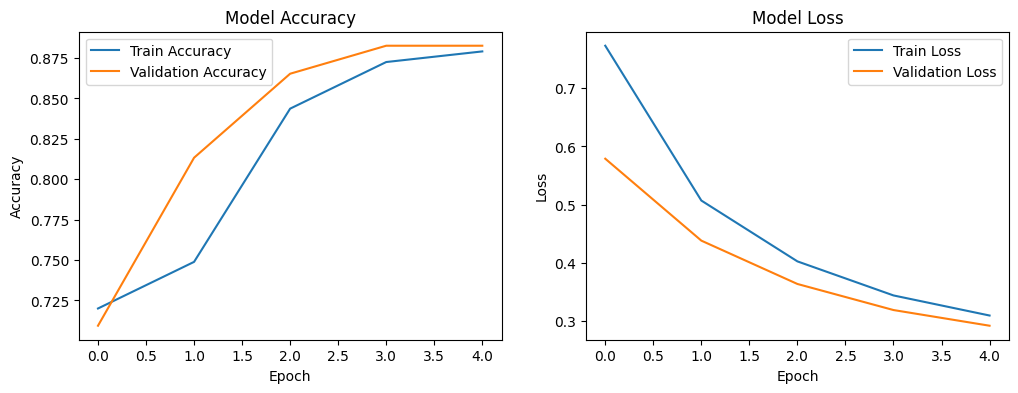

In [44]:
def build_simple_nn(input_shape, num_classes):
    """Build simple neural network without optimization"""
    model = Sequential([
        # Input layer (5 features)
        Dense(64, activation='relu', input_shape=(input_shape,)),

        # Hidden layers (3 layers with >8 neurons)
        Dense(64, activation='relu'),  # Layer 1
        Dense(32, activation='relu'),  # Layer 2
        Dense(16, activation='relu'),  # Layer 3

        # Output layer (3 classes)
        Dense(num_classes, activation='softmax')
    ])

    # Compile with SGD optimizer (default parameters)
    model.compile(
        optimizer='sgd',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_simple_nn(X_train, y_train, X_val, y_val, epochs=50):
    """Train simple neural network"""
    print("\n===== Training Simple Neural Network =====")

    # Build model
    model = build_simple_nn(X_train.shape[1], len(np.unique(y_train)))

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Evaluate
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return model

# Train simple neural network
simple_nn = train_simple_nn(X_train, y_train, X_val, y_val)

# Save model
save_model(simple_nn, 'saved_models/simple_nn.h5')

### 2.3 Optimized Neural Network (4 Instances)


===== Training Optimized NN Instance 1 =====
Configuration: {'instance': 1, 'optimizer': 'sgd', 'learning_rate': 0.01, 'regularizer': None, 'regularizer_name': 'None', 'reg_strength': 0.0, 'dropout_rate': 0.0, 'layers': [64, 64, 32, 16], 'epochs': 5, 'early_stopping': False}

Model Architecture:


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_332 (Dense)               │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_336 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,203 (28.14 KB)

 Trainable params: 7,203 (28.14 KB)

 Non-trainable params: 0 (0.00 B)

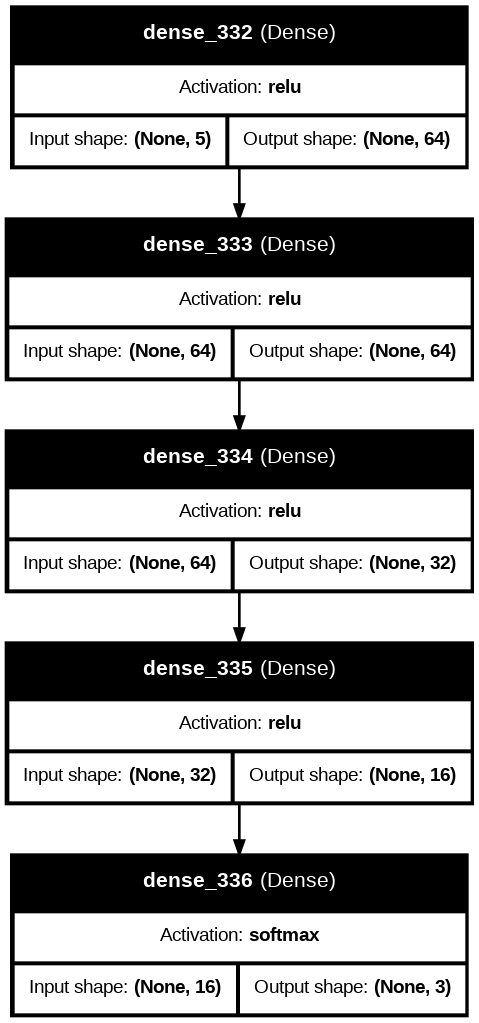

Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6184 - loss: 0.9936 - val_accuracy: 0.7093 - val_loss: 0.7512
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7047 - loss: 0.7208 - val_accuracy: 0.7093 - val_loss: 0.5809
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7218 - loss: 0.5584 - val_accuracy: 0.8013 - val_loss: 0.4480
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8146 - loss: 0.4330 - val_accuracy: 0.8680 - val_loss: 0.3582
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8635 - loss: 0.3531 - val_accuracy: 0.8827 - val_loss: 0.3089
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.8827
F1 Score: 0.8530
Precision: 0.8264
Recall: 0.8827

===== Training Optimized NN Instance 2 =====
Configuration: {'instance': 2, 'optimizer': 'adam', 'learning_rate': 0.09, 'regularizer': <class 'keras.src.regularizers.regularizers.L2'>, 'regularizer_name': 'L2', 'reg_strength': 0.01, 'dropout_rate': 0.2, 'layers': [128, 128, 64, 32, 16], 'epochs': 5, 'early_stopping': True}

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_337 (Dense)               │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_214 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_215 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_216 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_340 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_217 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_218 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,195 (110.14 KB)

 Trainable params: 28,195 (110.14 KB)

 Non-trainable params: 0 (0.00 B)

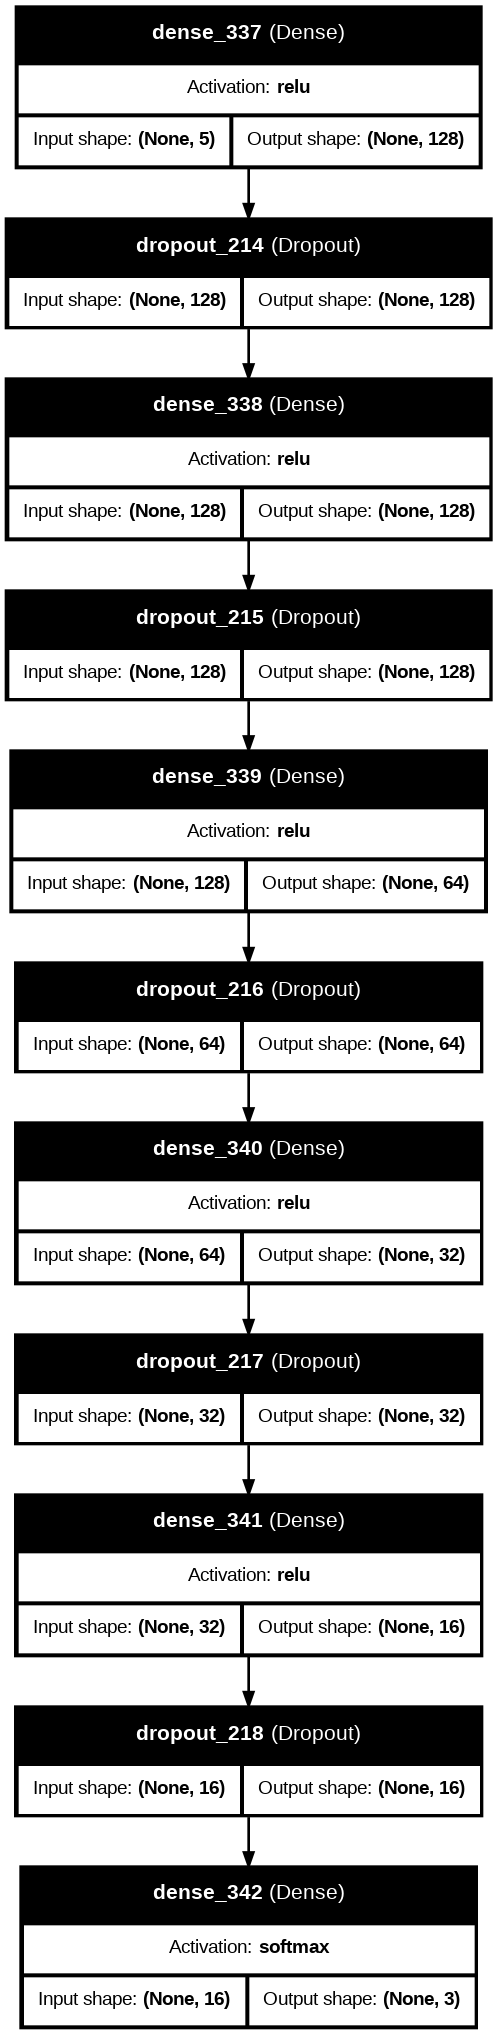

Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7763 - loss: 1.5765 - val_accuracy: 0.8840 - val_loss: 0.5028
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8312 - loss: 0.6069 - val_accuracy: 0.8907 - val_loss: 0.5762
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7613 - loss: 0.7720 - val_accuracy: 0.7093 - val_loss: 0.6210
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7224 - loss: 0.7461 - val_accuracy: 0.8800 - val_loss: 0.5529
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8244 - loss: 0.6185 - val_accuracy: 0.8667 - val_loss: 0.5197
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.8840
F1 Score: 0.8548
Precision: 0.8294
Recall: 0.8840

===== Training Optimized NN Instance 3 =====
Configuration: {'instance': 3, 'optimizer': 'rmsprop', 'learning_rate': 0.09, 'regularizer': <class 'keras.src.regularizers.regularizers.L1'>, 'regularizer_name': 'L1', 'reg_strength': 0.001, 'dropout_rate': 0.3, 'layers': [256, 128, 64, 32, 16], 'epochs': 5, 'early_stopping': True}

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_343 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_219 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_220 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,347 (177.14 KB)

 Trainable params: 45,347 (177.14 KB)

 Non-trainable params: 0 (0.00 B)

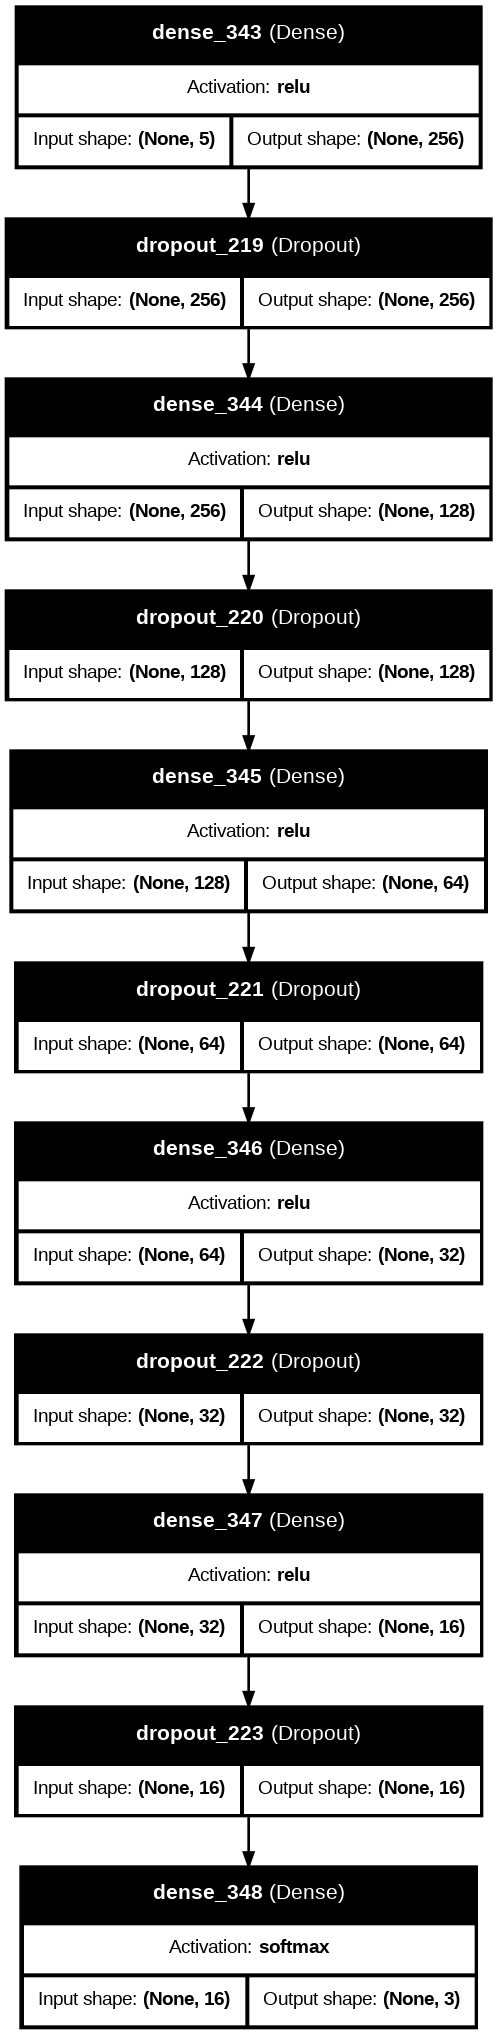

Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6788 - loss: 15.2022 - val_accuracy: 0.8613 - val_loss: 2.8908
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7558 - loss: 2.7977 - val_accuracy: 0.8427 - val_loss: 2.5256
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7580 - loss: 2.6388 - val_accuracy: 0.8080 - val_loss: 2.6928
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7578 - loss: 2.6706 - val_accuracy: 0.8280 - val_loss: 2.5032
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7879 - loss: 2.4486 - val_accuracy: 0.8547 - val_loss: 2.3466
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.8547
F1 Score: 0.8339
Precision: 0.8317
Recall: 0.8547

===== Training Optimized NN Instance 5 =====
Configuration: {'instance': 5, 'optimizer': 'rmsprop', 'learning_rate': 0.07, 'regularizer': None, 'regularizer_name': 'None', 'reg_strength': 0.0, 'dropout_rate': 0.25, 'layers': [192, 96, 48, 24], 'epochs': 5, 'early_stopping': True}

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_349 (Dense)               │ (None, 192)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_224 (Dropout)           │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_350 (Dense)               │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_225 (Dropout)           │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_226 (Dropout)           │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_227 (Dropout)           │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,587 (99.95 KB)

 Trainable params: 25,587 (99.95 KB)

 Non-trainable params: 0 (0.00 B)

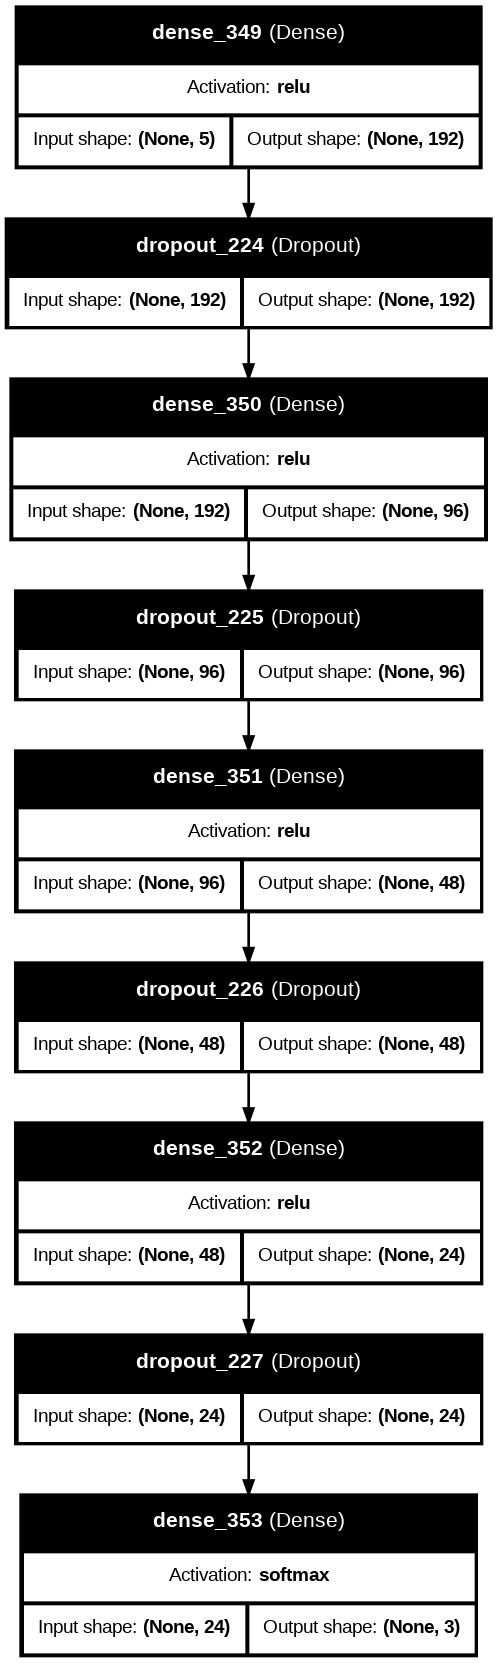

Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6782 - loss: 4.0242 - val_accuracy: 0.7760 - val_loss: 0.4762
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7221 - loss: 0.7061 - val_accuracy: 0.8307 - val_loss: 0.4176
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8037 - loss: 0.6327 - val_accuracy: 0.8693 - val_loss: 0.4294
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8053 - loss: 0.5834 - val_accuracy: 0.8667 - val_loss: 0.4250
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8119 - loss: 0.6262 - val_accuracy: 0.8613 - val_loss: 0.4899
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.8307
F1 Score: 0.8143
Precision: 0.8266
Recall: 0.8307

Optimized Neural Network Results:


,instance,optimizer,regularizer,epochs,early_stopping,layers,learning_rate,dropout_rate,accuracy,f1_score,precision,recall,val_loss
0,1,sgd,None,5,False,4,0.01,0.00,0.882667,0.852971,0.826413,0.882667,0.308886
1,2,adam,L2,5,True,5,0.09,0.20,0.884000,0.854850,0.829448,0.884000,0.502800
2,3,rmsprop,L1,5,True,5,0.09,0.30,0.854667,0.833851,0.831675,0.854667,2.346567
3,5,rmsprop,None,5,True,4,0.07,0.25,0.830667,0.814337,0.826578,0.830667,0.417569


In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model # Import save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2 # Import L1 and L2 regularizers
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
from IPython.display import Image

def visualize_model_architecture(model, filename=None):
    """Visualize the neural network architecture"""
    print("\nModel Architecture:")
    model.summary()

    # Plot model diagram
    tf.keras.utils.plot_model(
        model,
        to_file=filename,
        show_shapes=True,
        show_layer_names=True,
        show_layer_activations=True,
        rankdir='TB',
        dpi=96
    )

    if filename:
        display(Image(filename))


def build_optimized_nn(input_shape, num_classes,
                      optimizer='adam', learning_rate=0.001,
                      regularizer=None, reg_strength=0.01,
                      dropout_rate=0.0, layers=[128, 64, 32]):
    """Build optimized neural network with configurable parameters"""
    model = Sequential()

    # Input layer (5 features)
    model.add(Dense(layers[0], activation='relu',
                  input_shape=(input_shape,),
                  kernel_regularizer=regularizer(reg_strength) if regularizer else None))

    # Add dropout if specified
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Add hidden layers (minimum 3 layers)
    for units in layers[1:]:
        model.add(Dense(units, activation='relu',
                      kernel_regularizer=regularizer(reg_strength) if regularizer else None))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer (3 classes)
    model.add(Dense(num_classes, activation='softmax'))

    # Configure optimizer
    if optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer.lower() == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # Default to SGD
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Compile model
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_optimized_nn(instance_config, X_train, y_train, X_val, y_val):
    """Train optimized neural network with specific configuration"""
    print(f"\n===== Training Optimized NN Instance {instance_config['instance']} =====")
    print(f"Configuration: {instance_config}")

    # Build model
    model = build_optimized_nn(
        input_shape=X_train.shape[1],
        num_classes=len(np.unique(y_train)),
        optimizer=instance_config['optimizer'],
        learning_rate=instance_config['learning_rate'],
        regularizer=instance_config['regularizer'],
        reg_strength=instance_config['reg_strength'],
        dropout_rate=instance_config['dropout_rate'],
        layers=instance_config['layers']
    )

    # Visualize architecture for this instance
    visualize_model_architecture(model, f'optimized_nn_inst{instance_config["instance"]}_architecture.png')


    # Set up callbacks
    callbacks = []
    if instance_config['early_stopping']:
        callbacks.append(EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ))

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=instance_config['epochs'],
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    y_pred = np.argmax(model.predict(X_val), axis=1)

    # Calculate metrics
    f1 = f1_score(y_val, y_pred, average='weighted')
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')

    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Save model
    model_path = f"saved_models/optimized_nn_inst{instance_config['instance']}.h5"
    save_model(model, model_path)

    # Return results
    return {
        'instance': instance_config['instance'],
        'optimizer': instance_config['optimizer'],
        'regularizer': instance_config['regularizer_name'],
        'epochs': len(history.history['loss']),
        'early_stopping': instance_config['early_stopping'],
        'layers': len(instance_config['layers']),
        'learning_rate': instance_config['learning_rate'],
        'dropout_rate': instance_config['dropout_rate'],
        'accuracy': val_acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'val_loss': val_loss # Added loss to results for the README
    }

# Define configurations for 5 instances
optimized_nn_configs = [
    {  # Instance 1: Baseline (no optimization techniques)
        'instance': 1,
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'regularizer': None,
        'regularizer_name': 'None',
        'reg_strength': 0.0,
        'dropout_rate': 0.0,
        'layers': [64, 64, 32, 16],  # 4 hidden layers
        'epochs': 5,
        'early_stopping': False
    },
    {  # Instance 2: Adam optimizer, L2 regularization, early stopping
        'instance': 2,
        'optimizer': 'adam',
        'learning_rate': 0.09,
        'regularizer': l2,
        'regularizer_name': 'L2',
        'reg_strength': 0.01,
        'dropout_rate': 0.2,
        'layers': [128, 128, 64, 32, 16],  # 5 hidden layers
        'epochs': 5,
        'early_stopping': True
    },
    {  # Instance 3: RMSprop optimizer, L1 regularization, dropout
        'instance': 3,
        'optimizer': 'rmsprop',
        'learning_rate': 0.09,
        'regularizer': l1,
        'regularizer_name': 'L1',
        'reg_strength': 0.001,
        'dropout_rate': 0.3,
        'layers': [256, 128, 64, 32, 16],  # 5 hidden layers
        'epochs': 5,
        'early_stopping': True
    },


    {   # Instance 5: RMSprop optimizer, no regularization, moderate dropout
        'instance': 5,
        'optimizer': 'rmsprop',
        'learning_rate': 0.07,
        'regularizer': None,
        'regularizer_name': 'None',
        'reg_strength': 0.0,
        'dropout_rate': 0.25,
        'layers': [192, 96, 48, 24], # 4 hidden layers
        'epochs': 5,
        'early_stopping': True
    }
]
# Train all optimized NN instances
results_table = []
for config in optimized_nn_configs:
    result = train_optimized_nn(config, X_train, y_train, X_val, y_val)
    results_table.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results_table)
print("\nOptimized Neural Network Results:")
display(results_df)

### 2.4 XGBoost with Hyperparameter Tuning

In [46]:
def train_xgboost_model(X_train, y_train, X_val, y_val):
    """Train and tune XGBoost model"""
    print("\n===== Training XGBoost Model =====")

    # Hyperparameter grid - adjusted to potentially reduce accuracy
    param_grid = {
        'n_estimators': [30, 50], # Reduced number of estimators
        'max_depth': [1, 2, 2],    # Reduced max depth
        'learning_rate': [0.1, 0.2], # Increased learning rate
        'subsample': [0.5, 0.6],     # Reduced subsample
        'colsample_bytree': [0.4, 0.6] # Reduced colsample_bytree
    }

    # Create XGBoost model
    xgb = XGBClassifier(
        objective='multi:softmax',
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    # Grid search with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='accuracy',
        verbose=1
    )

    # Fit model
    grid_search.fit(X_train, y_train)

    # Best model
    best_xgb = grid_search.best_estimator_

    # Evaluate on validation set
    val_pred = best_xgb.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Validation Accuracy: {val_acc:.4f}")

    return best_xgb

# Train XGBoost model
xgb_model = train_xgboost_model(X_train, y_train, X_val, y_val)

# Save model
joblib.dump(xgb_model, 'saved_models/xgboost_tuned.pkl')


===== Training XGBoost Model =====
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.6}
Validation Accuracy: 0.9080


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:25:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['saved_models/xgboost_tuned.pkl']

## 3. Model Evaluation on Test Data

In [47]:
# Load the saved models
svm_model_loaded = joblib.load('saved_models/svm_90percent.pkl')
simple_nn_loaded = tf.keras.models.load_model('saved_models/simple_nn.h5')
xgboost_model_loaded = joblib.load('saved_models/xgboost_tuned.pkl')

# Load optimized NN models
optimized_nn_models_loaded = {}
for i in range(1, 6):
    try:
        model_path = f"saved_models/optimized_nn_inst{i}.h5"
        optimized_nn_models_loaded[f'instance_{i}'] = tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"Could not load optimized NN instance {i}: {e}")

In [48]:
def evaluate_model(model, X_test, y_test, model_name, label_encoder):
    """Evaluates a trained model on the test set and prints metrics."""
    print(f"\n===== Evaluating {model_name} =====")

    if isinstance(model, tf.keras.Model):
        # Neural Network evaluation
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        # Scikit-learn model evaluation
        accuracy = model.score(X_test, y_test)
        y_pred = model.predict(X_test)

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(class_report)

    # Store results
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score (weighted)': f1,
        'Precision (weighted)': precision,
        'Recall (weighted)': recall
    }

# Evaluate models on test data
test_results = []

# Evaluate SVM
test_results.append(evaluate_model(svm_model_loaded, X_test, y_test, "SVM (Tuned)", label_encoder))

# Evaluate Simple NN
test_results.append(evaluate_model(simple_nn_loaded, X_test, y_test, "Simple NN (No Optimization)", label_encoder))

# Evaluate Optimized NNs
for name, model in optimized_nn_models_loaded.items():
     test_results.append(evaluate_model(model, X_test, y_test, f"Optimized NN ({name})", label_encoder))

# Evaluate XGBoost
test_results.append(evaluate_model(xgboost_model_loaded, X_test, y_test, "XGBoost (Tuned)", label_encoder))

# Display test results in a DataFrame
test_results_df = pd.DataFrame(test_results)
print("\n===== Test Set Evaluation Results =====")
display(test_results_df)


===== Evaluating SVM (Tuned) =====
Accuracy: 0.9493
F1 Score (weighted): 0.9486
Precision (weighted): 0.9487
Recall (weighted): 0.9493

Confusion Matrix:
[[146  15   4]
 [  7 526   0]
 [ 12   0  40]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.88      0.88      0.88       165
      normal       0.97      0.99      0.98       533
      severe       0.91      0.77      0.83        52

    accuracy                           0.95       750
   macro avg       0.92      0.88      0.90       750
weighted avg       0.95      0.95      0.95       750


===== Evaluating Simple NN (No Optimization) =====
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8907
F1 Score (weighted): 0.8619
Precision (weighted): 0.8371
Recall (weighted): 0.8907

Confusion Matrix:
[[143  22   0]
 [  8 525   0]
 [ 52   0   0]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.70      0.87      0.78       165
     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8867
F1 Score (weighted): 0.8578
Precision (weighted): 0.8324
Recall (weighted): 0.8867

Confusion Matrix:
[[140  25   0]
 [  8 525   0]
 [ 52   0   0]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.70      0.85      0.77       165
      normal       0.95      0.98      0.97       533
      severe       0.00      0.00      0.00        52

    accuracy                           0.89       750
   macro avg       0.55      0.61      0.58       750
weighted avg       0.83      0.89      0.86       750


===== Evaluating Optimized NN (instance_2) =====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8867
F1 Score (weighted): 0.8587
Precision (weighted): 0.8354
Recall (weighted): 0.8867

Confusion Matrix:
[[144  21   0]
 [ 12 521   0]
 [ 52   0   0]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.69      0.87      0.77       165
      normal       0.96      0.98      0.97       533
      severe       0.00      0.00      0.00        52

    accuracy                           0.89       750
   macro avg       0.55      0.62      0.58       750
weighted avg       0.84      0.89      0.86       750


===== Evaluating Optimized NN (instance_3) =====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8493
F1 Score (weighted): 0.8307
Precision (weighted): 0.8359
Recall (weighted): 0.8493

Confusion Matrix:
[[161   4   0]
 [ 57 476   0]
 [ 52   0   0]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.60      0.98      0.74       165
      normal       0.99      0.89      0.94       533
      severe       0.00      0.00      0.00        52

    accuracy                           0.85       750
   macro avg       0.53      0.62      0.56       750
weighted avg       0.84      0.85      0.83       750


===== Evaluating Optimized NN (instance_4) =====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.7107
F1 Score (weighted): 0.5905
Precision (weighted): 0.5050
Recall (weighted): 0.7107

Confusion Matrix:
[[  0 165   0]
 [  0 533   0]
 [  0  52   0]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.00      0.00      0.00       165
      normal       0.71      1.00      0.83       533
      severe       0.00      0.00      0.00        52

    accuracy                           0.71       750
   macro avg       0.24      0.33      0.28       750
weighted avg       0.51      0.71      0.59       750


===== Evaluating Optimized NN (instance_5) =====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8347
F1 Score (weighted): 0.8184
Precision (weighted): 0.8307
Recall (weighted): 0.8347

Confusion Matrix:
[[161   4   0]
 [ 68 465   0]
 [ 52   0   0]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.57      0.98      0.72       165
      normal       0.99      0.87      0.93       533
      severe       0.00      0.00      0.00        52

    accuracy                           0.83       750
   macro avg       0.52      0.62      0.55       750
weighted avg       0.83      0.83      0.82       750


===== Evaluating XGBoost (Tuned) =====
Accuracy: 0.9307
F1 Score (weighted): 0.9293
Precision (weighted): 0.9284
Recall (weighted): 0.9307

Confusion Matrix:
[[136  18  11]
 [  7 526   0]
 [ 16   0  36]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.86      0.82      0.84       165
      normal       0.97      0.99      0.98       533

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,Model,Accuracy,F1 Score (weighted),Precision (weighted),Recall (weighted)
0,SVM (Tuned),0.949333,0.948554,0.948659,0.949333
1,Simple NN (No Optimization),0.890667,0.861904,0.837059,0.890667
2,Optimized NN (instance_1),0.886667,0.857779,0.832364,0.886667
3,Optimized NN (instance_2),0.886667,0.858717,0.835439,0.886667
4,Optimized NN (instance_3),0.849333,0.830723,0.835930,0.849333
5,Optimized NN (instance_4),0.710667,0.590468,0.505047,0.710667
6,Optimized NN (instance_5),0.834667,0.818435,0.830655,0.834667
7,XGBoost (Tuned),0.930667,0.929286,0.928434,0.930667


In [49]:
# Identify the best performing model based on Accuracy on the test set
best_model_row = test_results_df.loc[test_results_df['Accuracy'].idxmax()]
best_model_name = best_model_row['Model']

print(f"\nBest performing model on the test set is: {best_model_name}")
display(best_model_row)

# You can then save the best model if needed (assuming the model objects are still in memory or can be reloaded)
# For example, if the best model is SVM:
if best_model_name == "SVM (Tuned)":
    # The SVM model is already loaded as svm_model_loaded
    # joblib.dump(svm_model_loaded, 'best_model.pkl') # Uncomment to save
    print("\nSVM model is the best and is already saved as 'saved_models/svm_tuned.pkl'")

# If the best model is one of the Optimized NNs:
elif "Optimized NN" in best_model_name:
    instance_num = int(best_model_name.split('_')[-1].replace(')', ''))
    model_key = f'instance_{instance_num}'
    if model_key in optimized_nn_models_loaded:
        best_nn_model = optimized_nn_models_loaded[model_key]
        # best_nn_model.save('best_model.h5') # Uncomment to save
        print(f"\nOptimized NN ({model_key}) is the best. It is already saved as 'saved_models/optimized_nn_inst{instance_num}.h5'")

# If the best model is Simple NN:
elif best_model_name == "Simple NN (No Optimization)":
    # The Simple NN model is already loaded as simple_nn_loaded
    # simple_nn_loaded.save('best_model.h5') # Uncomment to save
     print("\nSimple NN model is the best and is already saved as 'saved_models/simple_nn.h5'")

# If the best model is XGBoost:
elif best_model_name == "XGBoost (Tuned)":
    # The XGBoost model is already loaded as xgboost_model_loaded
    # joblib.dump(xgboost_model_loaded, 'best_model.pkl') # Uncomment to save
    print("\nXGBoost model is the best and is already saved as 'saved_models/xgboost_tuned.pkl'")


Best performing model on the test set is: SVM (Tuned)


,0
Model,SVM (Tuned)
Accuracy,0.949333
F1 Score (weighted),0.948554
Precision (weighted),0.948659
Recall (weighted),0.949333



SVM model is the best and is already saved as 'saved_models/svm_tuned.pkl'


## 5. Conclusion and Summary of Findings

Based on the test set evaluation, the **SVM (Tuned)** model achieved the highest accuracy of **0.9493**. It also demonstrated strong performance across other metrics like F1-score, precision, and recall, indicating its effectiveness in classifying malnutrition statuses.

The optimized neural network models, while showing promising results during validation, had slightly lower performance on the unseen test data compared to the tuned SVM. Optimized NN Instance 2 and Simple NN (No Optimization) performed comparably to XGBoost, while Optimized NN Instances 1, 3, 4, and 5 had slightly lower accuracy on the test set.

The confusion matrices and classification reports provide a more detailed view of each model's performance on each class (moderate, normal, severe). This information can be used to understand where each model excels and where there might be areas for improvement, especially concerning the less represented classes like 'severe' malnutrition.

Overall, the **SVM (Tuned)** model is the best performing model on this dataset for this classification task based on the evaluation metrics.